In [1]:
from google.colab import drive
import os

drive.mount('/content/gdrive', force_remount=True)
os.chdir(r'/content/gdrive/MyDrive/Швы')

Mounted at /content/gdrive


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [48]:
# import zipfile
# os.chdir(r'/content/gdrive/MyDrive/Швы')
# with zipfile.ZipFile('dataset.zip', 'r') as zip_obj:
#    # Extract all the contents of zip file in current directory
#    os.chdir(r'/content/gdrive/MyDrive/Швы/Данные')
#    zip_obj.extractall()

print('After zip extraction:')
print(os.listdir())

After zip extraction:
['dataset.zip', 'Данные', '1_дефект 0_нет_дефекта', 'my_resnet18.pth']


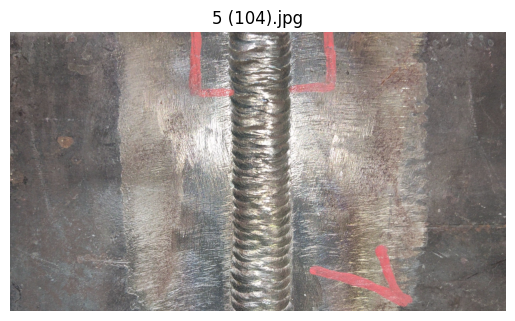

In [3]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import shutil

# folder_path = '/content/drive/My Drive/Швы/Данные/NewFolder'

# # Проверка, что папка существует
# if os.path.exists(folder_path) and os.path.isdir(folder_path):
#     shutil.rmtree(folder_path)
#     print(f'Folder {folder_path} has been deleted.')
# else:
#     print(f'Folder {folder_path} does not exist or is not a directory.')

# Путь к папке с изображениями на Google Диске
# folder_path = '/content/drive/My Drive/Швы/Данные'

# Получаем список всех файлов в папке
os.chdir(r'/content/gdrive/MyDrive/Швы/Данные')

image_files = [f for f in os.listdir() if f.endswith(('.png', '.jpg', '.jpeg'))]
text_files = [f for f in os.listdir() if f.endswith('.txt')]

# Проверяем, что в папке есть хотя бы одно изображение
if image_files:
    # Выбираем первое изображение из списка
    first_image_file = image_files[29]

    # Полный путь к изображению
    # img_path = os.path.join('/content/drive/My Drive/Швы/Данные', first_image_file)

    # Чтение изображения
    img = mpimg.imread(first_image_file)

    # Отображение изображения
    plt.imshow(img)
    plt.axis('off')  # Отключаем отображение осей
    plt.title(first_image_file)
    plt.show()
else:
    print("В папке нет изображений.")


In [4]:
normal, wrong = [], []

for name in text_files:
    with open(name, 'r') as file:
        data = file.readlines()
        if data:
            wrong.append(name)
        else:
            normal.append(name)

In [5]:
len(normal), len(wrong)

(140, 1023)

In [ ]:
df = pd.DataFrame([0 for i in range(len(normal))] + [1 for i in range(len(wrong))], [i.strip('.txt') for i in normal] + [i.strip('.txt') for i in wrong], columns=['target']).reset_index()
df.drop(index=1162, inplace=True)

In [ ]:
# os.chdir(r'/content/gdrive/MyDrive/Швы')
# df.to_csv('1_дефект 0_нет_дефекта')

In [6]:
wrong.remove('classes.txt')
'classes.txt' in wrong

False

In [7]:
import torch
from torchvision import transforms
from PIL import Image
import re


os.chdir(r'/content/gdrive/MyDrive/Швы/Данные')

transform1 = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.ColorJitter(0.6, 0.6, 0.3, 0.3),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

transform2 = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.ColorJitter(0.6, 0.6, 0.3, 0.3),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

transform3 = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.ColorJitter(0.6, 0.6, 0.3, 0.3),
    transforms.RandomRotation(20),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

images_norm = []
for image_path in normal:
    image = Image.open(re.sub(r'\.txt', '.jpg', image_path))
    image1 = transform1(image)
    image2 = transform2(image)
    image3 = transform3(image)
    images_norm.append(image1)
    images_norm.append(image2)
    images_norm.append(image3)

images_norm = torch.stack(images_norm)

# Проверка формы тензора
print(images_norm.shape)

images_wrong = []

for image_path in wrong:
    image = Image.open(re.sub(r'\.txt', '.jpg', image_path))
    image1 = transform1(image)
    images_wrong.append(image1)

images_wrong = torch.stack(images_wrong)

# Проверка формы тензора
print(images_wrong.shape)

torch.Size([420, 3, 224, 224])
torch.Size([1022, 3, 224, 224])


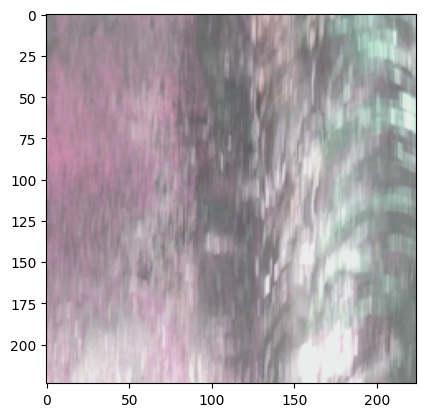

In [8]:
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
plt.imshow(images_norm[75].permute(1, 2, 0).numpy() * std + mean);

In [9]:
images_wn = torch.cat((images_wrong, images_norm), dim=0)
images_wn.shape

torch.Size([1442, 3, 224, 224])

In [10]:
y = torch.tensor(np.array([1 for i in range(images_wrong.shape[0])] + [0 for i in range(images_norm.shape[0])])).long()
y.shape

torch.Size([1442])

In [11]:
del images_wrong
del images_norm

In [12]:
from sklearn.model_selection import train_test_split

x_train, x_val, y_train, y_val = train_test_split(images_wn, y, test_size=0.2, random_state=42, shuffle=True, stratify=y)

del images_wn

In [13]:
class net(torch.nn.Module):
    def __init__(self):
        super(net, self).__init__()
        self.batch_norm0 = torch.nn.BatchNorm1d(512 * 2)

        self.fc_1= torch.nn.Linear(512 * 2, 128 * 2)
        self.act_1=torch.nn.ELU()
        self.batch_norm1 = torch.nn.BatchNorm1d(128 * 2)

        self.fc_2 =torch.nn.Linear(128 * 2, 32)
        self.act_2=torch.nn.ELU()
        self.batch_norm2 = torch.nn.BatchNorm1d(32)

        # self.fc_3 =torch.nn.Linear(32, 8)
        # self.act_3=torch.nn.ELU()
        # self.batch_norm3 = torch.nn.BatchNorm1d(16)

        self.fc_4 = torch.nn.Linear(32, 2)

        self.sm = torch.nn.Softmax(dim=1)

    def forward(self, x):
        x = self.batch_norm0(x)
        x=self.fc_1(x)
        x=self.act_1(x)
        x = self.batch_norm1(x)

        x=self.fc_2(x)
        x=self.act_2(x)
        x = self.batch_norm2(x)

        # x=self.fc_3(x)
        # x=self.act_3(x)
        # x = self.batch_norm3(x)

        x = self.fc_4(x)
        return x

    def inference(self, x):
        x = self.forward(x)
        x = self.sm(x)
        return x


In [14]:
from torchvision import models

#model = models.resnet18(pretrained=True)
model = torch.hub.load('pytorch/vision:v0.10.0', 'googlenet', pretrained=True)

# Disable grad for all conv layers
for param in model.parameters():
    param.requires_grad = False

model.fc = net()


loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1.0e-3)

# Decay LR by a factor of 0.1 every 7 epochs
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

Downloading: "https://github.com/pytorch/vision/zipball/v0.10.0" to /root/.cache/torch/hub/v0.10.0.zip
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /root/.cache/torch/hub/checkpoints/googlenet-1378be20.pth
100%|██████████| 49.7M/49.7M [00:00<00:00, 88.2MB/s]


In [15]:
num_epochs = 50
test_accuracy_history = []
test_loss_history = []
batch_size = 200

for epoch in range(num_epochs):
    order = np.random.permutation(len(x_train))
    for start_index in range(0, len(x_train), batch_size):
        optimizer.zero_grad()
        model.train()
        batch_indexes = order[start_index:start_index + batch_size]

        x_batch = x_train[batch_indexes]#.to(device)
        y_batch = y_train[batch_indexes]#.to(device)
        preds = model.forward(x_batch)
        preds_prob = torch.nn.functional.softmax(preds)

        loss_value = loss(preds, y_batch)
        loss_value.backward()

        optimizer.step()
    scheduler.step()
    model.eval()
    test_preds = model.forward(x_val)
    test_loss_history.append(loss(test_preds, y_val).data)
    # if loss(test_preds, y_test).data < 0.6:
    #     break

    accuracy = (test_preds.argmax(dim=1) == y_val).float().mean().data
    test_accuracy_history.append(accuracy)

    print(epoch, accuracy, test_loss_history[-1])

<ipython-input-15-ca8b33fa6e9a>:16: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  preds_prob = torch.nn.functional.softmax(preds)


0 tensor(0.8166) tensor(0.5004)
1 tensor(0.8201) tensor(0.4351)
2 tensor(0.8374) tensor(0.3877)
3 tensor(0.8547) tensor(0.3460)
4 tensor(0.8616) tensor(0.3260)
5 tensor(0.8685) tensor(0.3082)
6 tensor(0.8581) tensor(0.3079)
7 tensor(0.8616) tensor(0.3104)
8 tensor(0.8581) tensor(0.3096)
9 tensor(0.8547) tensor(0.3078)


KeyboardInterrupt: 

Здесь по графику лоса было видно, что после 3 эпох происходит переобучение, так что обучаем 4 раза

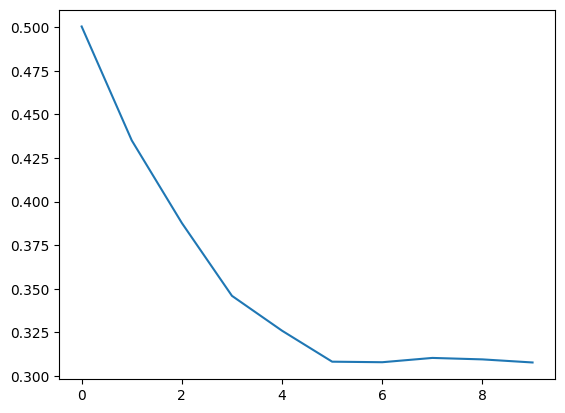

In [16]:
plt.plot(test_loss_history)

In [17]:
model.eval()
y_pred4 = model.forward(x_val)
y_score4 = torch.nn.functional.softmax(y_pred4).detach().numpy()
y_pred4 = y_pred4.argmax(dim=1).detach().numpy()

<ipython-input-17-7692bc39ed96>:3: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_score4 = torch.nn.functional.softmax(y_pred4).detach().numpy()


accuracy is 0.8546712802768166
f1 is 0.896551724137931
precision is 0.9054726368159204
recall is 0.8878048780487805


ValueError: The number of FixedLocator locations (2), usually from a call to set_ticks, does not match the number of labels (289).

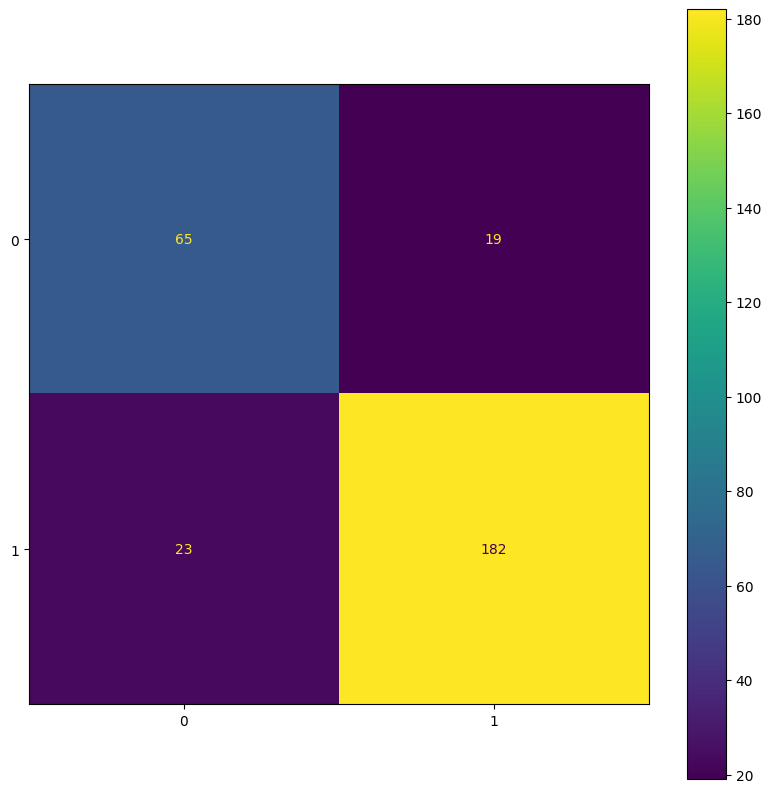

In [18]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix

from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import roc_curve, roc_auc_score


print(f'accuracy is {accuracy_score(y_val, y_pred4)}')
print(f'f1 is {f1_score(y_val, y_pred4)}')
print(f'precision is {precision_score(y_val, y_pred4)}')
print(f'recall is {recall_score(y_val, y_pred4)}')
conf_matrix = confusion_matrix(y_val, y_pred4)

fig, ax = plt.subplots(figsize=(10,10), dpi=100)

display = ConfusionMatrixDisplay(conf_matrix, display_labels=set(y_val))

display.plot(ax=ax)

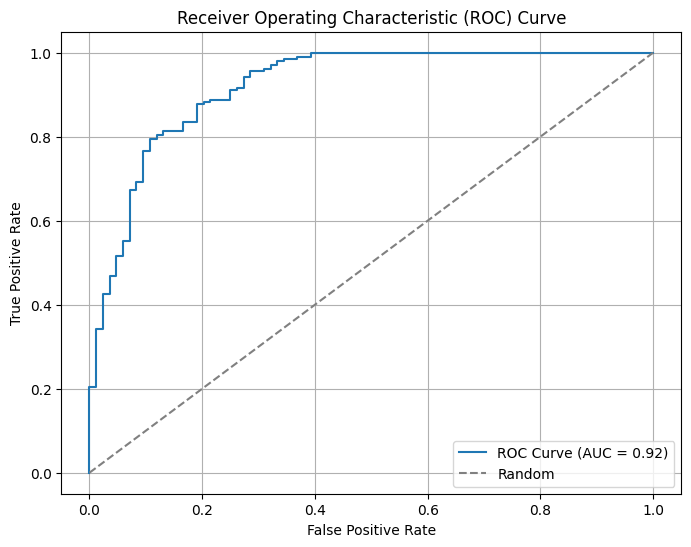

In [19]:
# Предположим, что y_true - истинные метки классов, y_score - оценки вероятностей классов (например, вероятности класса 1)
fpr, tpr, thresholds = roc_curve(y_val, y_score4[:, 1])

# Вычислим площадь под ROC-кривой (AUC)
auc = roc_auc_score(y_val, y_score4[:, 1])

# Построим ROC-кривую
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.grid(True)
plt.show()

In [20]:
os.chdir(r'/content/gdrive/MyDrive/Швы')
model_scripted = torch.jit.script(model) # Export to TorchScript
model_scripted.save('my_googlenet.pt') # Save

In [ ]:
model1 = torch.load('my_resnet18.pth')

In [ ]:
model1.eval()
y_pred = model1.forward(x_val)
y_score = torch.nn.functional.softmax(y_pred).detach().numpy()

<ipython-input-39-39a6293cc47e>:3: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_score = torch.nn.functional.softmax(y_pred).detach().numpy()


In [75]:
model1.forward(x_val[0, :, :, :].unsqueeze(0))

tensor([[-0.8855,  0.5927]], grad_fn=<AddmmBackward0>)